In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import gc
import shutil
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LSTM
import tensorflow.keras
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
import tensorflow.keras.metrics
from tensorflow.keras.metrics import AUC
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
from sklearn.utils import shuffle
import time
import pickle
from attention_layer_py import AttentionLayer
from utils import my_precision,my_recall,my_f1,my_roc_auc,get_specificity,get_balanced_acc,plotConfusionMatrix,plotCurves,progressBar,plotROCCurve

2025-04-23 10:42:49.437236: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745404969.898723      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745404970.028726      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def plotCurves2(title, x, y, curve, histories, save_path=None):
    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(figsize=(10, 6))
    train_all = []
    val_all = []

    min_len = min([len(entry[curve]) for entry in histories])

    for entry in histories:
        train_curve = entry[curve][:min_len]
        val_curve = entry['val_' + curve][:min_len]
        plt.plot(train_curve, ls='dashed', alpha=0.2, color='tomato')
        plt.plot(val_curve, ls='dashed', alpha=0.2, color='teal')
        train_all.append(train_curve)
        val_all.append(val_curve)

    train_avg = np.mean(train_all, axis=0)
    val_avg = np.mean(val_all, axis=0)

    plt.plot(train_avg, ls='-', lw=2, label='Average train ' + curve, color='tomato')
    plt.plot(val_avg, ls='-', lw=2, label='Average val ' + curve, color='teal')

    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path)
        print(f"Saved plot to {save_path}")
    plt.show()

def plotConfusionMatrix2(y_true, y_pred, save_path=None):
    import matplotlib.pyplot as plt
    import seaborn as sn
    import pandas as pd
    import numpy as np
    from sklearn.metrics import confusion_matrix

    conf_matrix = confusion_matrix(y_true, y_pred)
    norm_array = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in norm_array.flatten()]
    labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    df_cm = pd.DataFrame(conf_matrix, range(2), range(2))

    plt.figure(figsize=(6, 5))
    ax = sn.heatmap(df_cm, annot=labels, fmt='', cmap='Greens', cbar=False)
    ax.set_title('CNN model confusion matrix')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values')
    ax.xaxis.set_ticklabels(['No Upper Infection', 'Upper Infection'])
    ax.yaxis.set_ticklabels(['No Upper Infection', 'Upper Infection'], va="center")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Saved confusion matrix to {save_path}")
    plt.show()

In [3]:
spectrogram_path = "/kaggle/input/datasss/augmented_spectrograms2/augmented_spectrograms2"
labels_path = "/kaggle/input/datasss/labels_new.csv"

# Read the labels
labels = pd.read_csv(labels_path)
covid_status = np.array(labels['label'])

# List all files in the spectrogram directory and ensure they are sorted correctly
spectrogram_files = sorted(os.listdir(spectrogram_path), key=lambda x: int(os.path.splitext(x)[0]))

# Ensure that the number of files and labels match
if len(spectrogram_files) != len(covid_status):
    print(f"The number of spectrogram files ({len(spectrogram_files)}) does not match the number of labels ({len(covid_status)})")
else:
    print(f"Spectrogram files count: {len(spectrogram_files)}")
    print(f"Labels count: {len(covid_status)}")

# Now load the spectrograms and check if they match the labels
images = []
for filename in spectrogram_files:
    img = cv2.imread(os.path.join(spectrogram_path, filename))
    img = cv2.resize(img, (88, 39))  # Resize to match input size
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.asarray(img, dtype=np.float32)
    img = img / 225.0  # Normalize image
    images.append(img)

images = np.array(images)

# Ensure that labels are aligned with spectrograms by order
sorted_labels = labels.iloc[:len(spectrogram_files)]  # Ensure the number of rows in labels matches the spectrograms
labels_aligned = sorted_labels['label'].values  # Extract the aligned labels

# Reshaping the images based on Keras data format
imgArraySize = (88, 39)
rows, cols = imgArraySize

if K.image_data_format() == 'channels_first':
    images = images.reshape(images.shape[0], 3, rows, cols)
    input_shape = (3, rows, cols)
else:
    images = images.reshape(images.shape[0], rows, cols, 3)
    input_shape = (rows, cols, 3)

print("Dataset count: ", len(images), " Shape: ", images.shape)
print("Labels count: ", len(labels_aligned), " Shape: ", labels_aligned.shape)
print("Sample:")
print("Label: ", labels_aligned[0])

np.random.seed(75)

images,covid_status = shuffle(images,covid_status, random_state=75)
(trainX,testX,trainY,testY) = train_test_split(images,covid_status,test_size=0.2,shuffle=True)

np.save('trainX.npy', trainX)
np.save('trainY.npy', trainY)
np.save('testX.npy', testX)
np.save('testY.npy', testY)

del images,covid_status

print("Train set size : ",len(trainX))
print("Test set size : ",len(testX))

## Evaluation metrics
scoring = {'accuracy': 'accuracy',
           'precision': make_scorer(my_precision),
           'recall':make_scorer(my_recall),
           'roc_auc':make_scorer(my_roc_auc),
           'f1':make_scorer(my_f1),
           'balanced_accuracy': 'balanced_accuracy'}

## Start 5-fold cross-validation
num_folds = 5
fold_no = 1

acc_per_fold = []
recall_per_fold = []
precision_per_fold = []
roc_auc_per_fold = []
f1_per_fold = []
balanced_acc = []
specificity_per_fold = []
loss_per_fold = []
histories = []

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

METRICS = [
    tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
    tensorflow.keras.metrics.Precision(name='precision'),
    tensorflow.keras.metrics.Recall(name='recall'),
    tensorflow.keras.metrics.AUC(name='auc')
]

kfold = KFold(n_splits=num_folds, shuffle=True,random_state=75)
print('Done')

Spectrogram files count: 10143
Labels count: 10143
Dataset count:  10143  Shape:  (10143, 88, 39, 3)
Labels count:  10143  Shape:  (10143,)
Sample:
Label:  0
Train set size :  8114
Test set size :  2029
Done


I0000 00:00:1745405115.244074      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745405115.244752      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [4]:
from tensorflow.keras import Input, Model
from keras.optimizers import AdamW
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

weight_decay = 2e-4
learning_rate = 0.001
epochs = 100
batch_size = 256

for train, test in kfold.split(trainX, trainY):
    optimizer = AdamW(weight_decay=weight_decay, learning_rate=learning_rate)

    filepath = "lstm_model_best_weights_" + str(fold_no) + ".keras"
    checkpoint = ModelCheckpoint(filepath, monitor='val_auc',#'val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    inputs = Input(shape=trainX[0].shape, name='input')
    x = Reshape((88, 117))(inputs)  # 88 time steps, 117 features

    # LSTM layers with dropout
    x = LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(x)
    x = LSTM(256, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)(x)
    x = Dropout(0.3)(x)
    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(1, name='output_layer')(x)
    x = Activation('sigmoid')(x)

    model = Model(inputs=inputs, outputs=x)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=METRICS)

    start = time.time()
    history = model.fit(
        trainX[train], trainY[train],
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(trainX[test], trainY[test]),
        callbacks=[checkpoint]#, early_stop]
    )
    end = time.time()
    print("Training time : ", (end - start))

    train_losses.extend(history.history['loss'])
    val_losses.extend(history.history['val_loss'])
    train_accuracies.extend(history.history['accuracy'])
    val_accuracies.extend(history.history['val_accuracy'])
    histories.append(history)

    scores = model.evaluate(trainX[test], trainY[test], verbose=0)
    covPredict = model.predict(trainX[test])
    covPredict = np.where(covPredict >= 0.5, 1, 0)
    real_stat = trainY[test]
    acc_per_fold.append(scores[1])
    recall_per_fold.append(my_recall(real_stat, covPredict))
    precision_per_fold.append(my_precision(real_stat, covPredict))
    roc_auc_per_fold.append(my_roc_auc(real_stat, covPredict))
    f1_per_fold.append(my_f1(real_stat, covPredict))
    balanced_acc.append(get_balanced_acc(real_stat, covPredict))
    specificity_per_fold.append((2 * get_balanced_acc(trainY[test], covPredict)) - my_recall(trainY[test], covPredict))
    loss_per_fold.append(scores[0])

    model = load_model(filepath)
    score = model.evaluate(trainX[test], trainY[test], verbose=0)
    covPredict = model.predict(trainX[test])
    covPredict = np.where(covPredict > 0.5, 1, 0)

    print("Validation results for the fold " + str(fold_no) + ":")
    print("Accuracy : ", score[1])
    print("Precision : ", my_precision(trainY[test], covPredict))
    print("Recall : ", my_recall(trainY[test], covPredict))
    print("F1 : ", my_f1(trainY[test], covPredict))
    print("ROC AUC : ", my_roc_auc(trainY[test], covPredict))
    print("Specificity : ", (2 * get_balanced_acc(trainY[test], covPredict)) - my_recall(trainY[test], covPredict))

    score = model.evaluate(testX, testY, verbose=0)
    covPredict = model.predict(testX)
    covPredict = np.where(covPredict >= 0.5, 1, 0)

    print("Test results for the fold " + str(fold_no) + ":")
    print("Accuracy : ", score[1])
    print("Precision : ", my_precision(testY, covPredict))
    print("Recall : ", my_recall(testY, covPredict))
    print("F1 : ", my_f1(testY, covPredict))
    print("ROC AUC : ", my_roc_auc(testY, covPredict))
    print("Specificity : ", (2 * get_balanced_acc(testY, covPredict)) - my_recall(testY, covPredict))

    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.4964 - auc: 0.4910 - loss: 0.8660 - precision: 0.4335 - recall: 0.4551
Epoch 1: val_auc improved from -inf to 0.50646, saving model to lstm_model_best_weights_1.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 259ms/step - accuracy: 0.4967 - auc: 0.4913 - loss: 0.8646 - precision: 0.4336 - recall: 0.4543 - val_accuracy: 0.5484 - val_auc: 0.5065 - val_loss: 0.6906 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.5181 - auc: 0.5056 - loss: 0.7604 - precision: 0.4439 - recall: 0.3579
Epoch 2: val_auc did not improve from 0.50646
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 0.5179 - auc: 0.5053 - loss: 0.7603 - precision: 0.4436 - recall: 0.3577 - val_accuracy: 0.5484 - val_auc: 0.5004 - val_loss: 0.6933 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 

In [5]:
histories_slim = [h.history for h in histories]
with open('histories_slim.pkl', 'wb') as f:
    pickle.dump(histories_slim, f)

In [6]:
## Best fold based on test ROC AUC ##
best_fold_idx = np.argmax(roc_auc_per_fold)
best_auc = roc_auc_per_fold[best_fold_idx]
best_fold_number = best_fold_idx + 1

print("\n=== Summary of Test ROC AUCs per Fold ===")
for i, auc_val in enumerate(roc_auc_per_fold):
    print(f"Fold {i + 1}: AUC = {auc_val:.4f}")

# Adjust model filename to match fold number starting from 1
best_model_path = f"lstm_model_best_weights_{best_fold_number}.keras"
if os.path.exists(best_model_path):
    shutil.copyfile(best_model_path, "best_lstm_model.keras")

print(f"\n Best fold: {best_fold_number} with AUC = {best_auc:.4f}")


=== Summary of Test ROC AUCs per Fold ===
Fold 1: AUC = 0.7273
Fold 2: AUC = 0.7308
Fold 3: AUC = 0.7433
Fold 4: AUC = 0.7099
Fold 5: AUC = 0.7041

 Best fold: 3 with AUC = 0.7433


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step
Saved confusion matrix to confusion_matrix.pdf


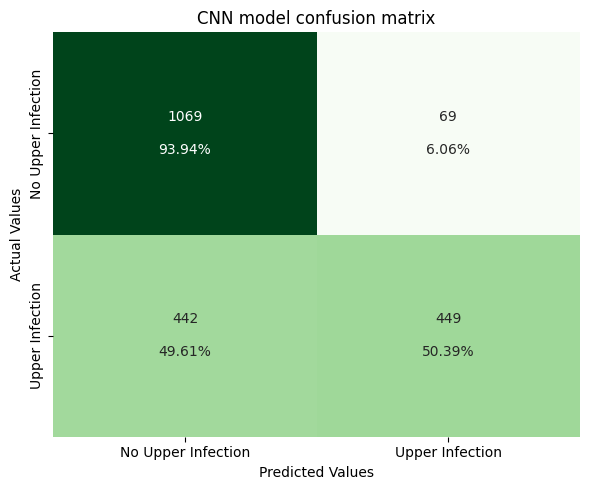

Saved plot to accuracy_curve.pdf


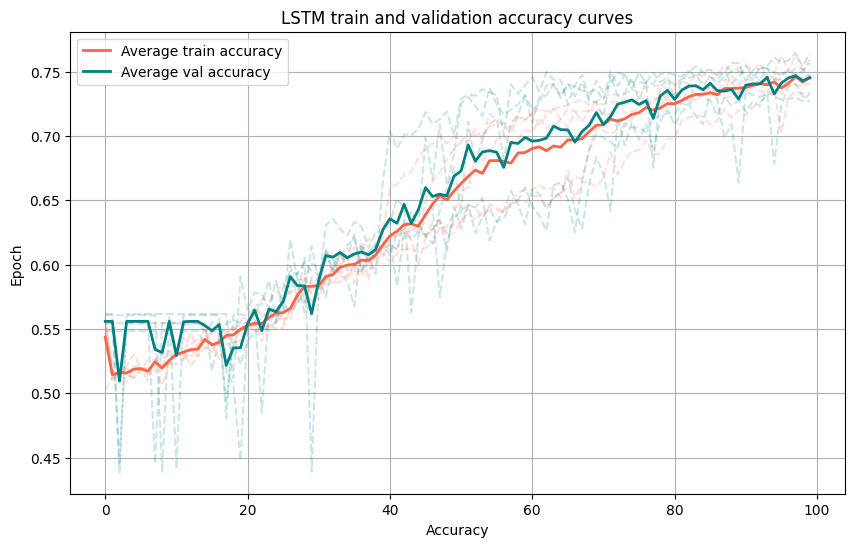

Saved plot to loss_curve.pdf


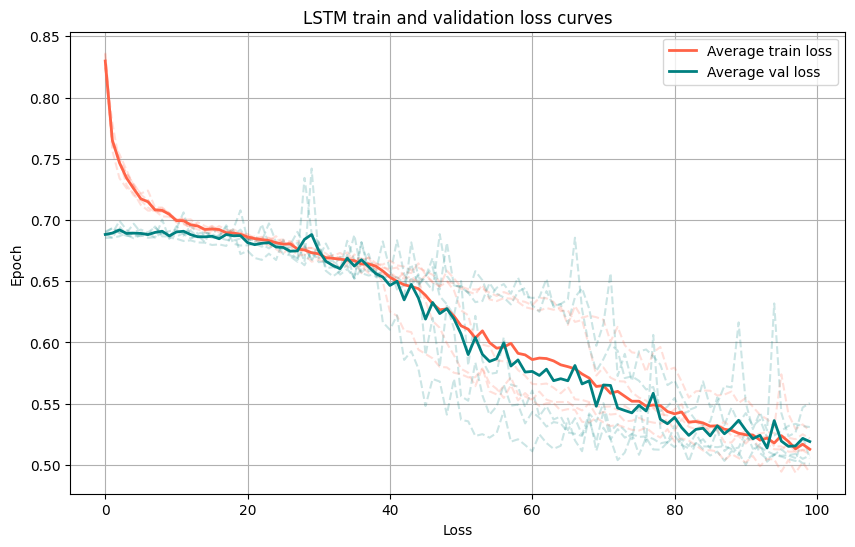

Saved plot to sensitivity_curve.pdf


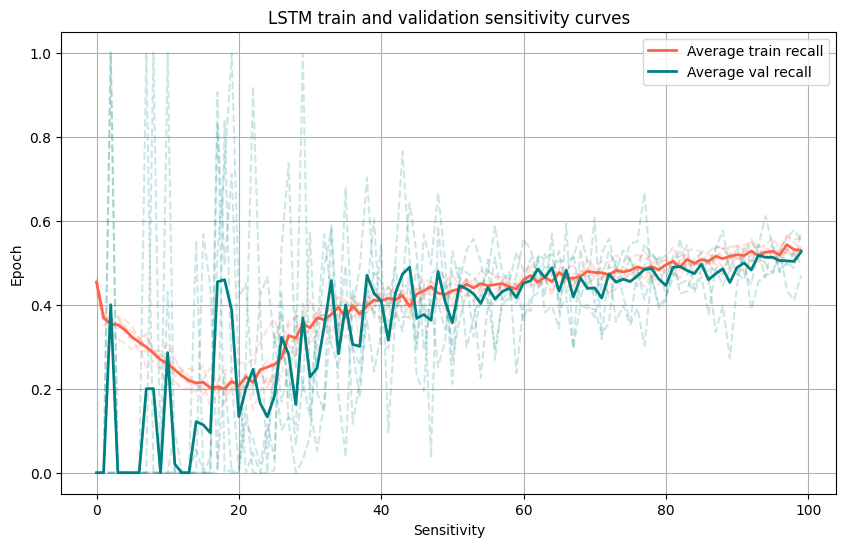

Saved plot to precision_curve.pdf


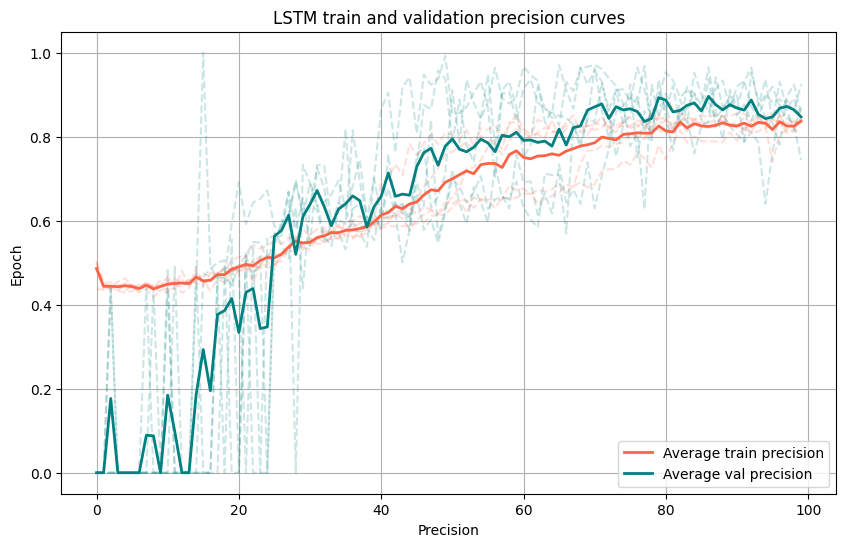

64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step
AUC SCORE:  0.7738653869292417


In [7]:
model = load_model(best_model_path)

# Load test data
testX = np.load('testX.npy')
testY = np.load('testY.npy')

# Model Evaluation
score = model.evaluate(testX, testY, verbose=0)
covPredict = model.predict(testX)
covPredict = np.where(covPredict >= 0.5, 1, 0)

np.save('covPredict_best_model.npy', covPredict)

###########
## PLOTS ##
###########

# Confusion matrix
plotConfusionMatrix2(testY, covPredict, save_path="confusion_matrix.pdf")

# Accuracy curves
plotCurves2('LSTM train and validation accuracy curves', 'Accuracy', 'Epoch', 'accuracy', histories_slim, save_path="accuracy_curve.pdf")

# Loss curves
plotCurves2('LSTM train and validation loss curves', 'Loss', 'Epoch', 'loss', histories_slim, save_path="loss_curve.pdf")

# Sensitivity curves
plotCurves2('LSTM train and validation sensitivity curves', 'Sensitivity', 'Epoch', 'recall', histories_slim, save_path="sensitivity_curve.pdf")

# Precision curves
plotCurves2('LSTM train and validation precision curves', 'Precision', 'Epoch', 'precision', histories_slim, save_path="precision_curve.pdf")

# ROC curve
probabilities = model.predict(testX).ravel()
np.save('probabilities_best_model.npy', probabilities)
fpr, tpr, thresholds = roc_curve(testY, probabilities, pos_label=1)
auc_score = auc(fpr, tpr)

print('AUC SCORE: ', auc_score)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("roc_curve.pdf", format='pdf')
plt.close()

In [8]:
model = load_model(best_model_path, custom_objects={'AttentionLayer': AttentionLayer})

# Feature extractor model that outputs the penultimate layer (before final sigmoid)
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('output_layer').input)

train_features = feature_extractor.predict(trainX)
test_features = feature_extractor.predict(testX)

np.save('train_embeddings.npy', train_features)
np.save('test_embeddings.npy', test_features)

254/254 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step


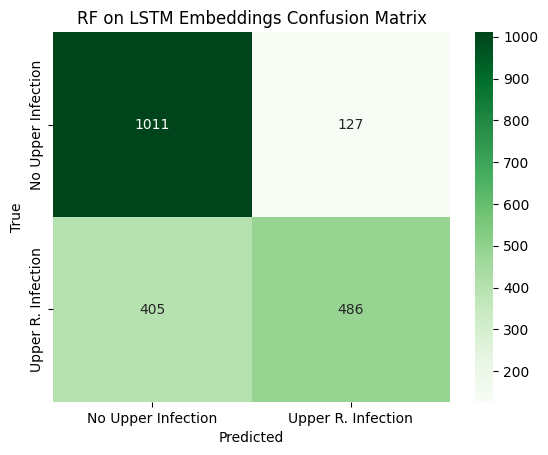

              precision    recall  f1-score   support

           0     0.7140    0.8884    0.7917      1138
           1     0.7928    0.5455    0.6463       891

    accuracy                         0.7378      2029
   macro avg     0.7534    0.7169    0.7190      2029
weighted avg     0.7486    0.7378    0.7278      2029

ROC AUC: 0.7654044842094052


In [9]:
#####################
####      RF      ###
#####################
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(train_features, trainY)

# Predict
rf_preds = rf.predict(test_features)
rf_probs = rf.predict_proba(test_features)[:, 1]

######################
## Confusion matrix ##
######################
cm = confusion_matrix(testY, rf_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Upper Infection', 'Upper R. Infection'],
            yticklabels=['No Upper Infection', 'Upper R. Infection'])
plt.title("RF on LSTM Embeddings Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#############
## Metrics ##
#############
print(classification_report(testY, rf_preds, digits=4))
print("ROC AUC:", roc_auc_score(testY, rf_probs))

In [10]:
##########################################
## ENSEMBLE PREDICTIONS FOR BOTH MODELS ##
##########################################

# Predicted probabilities from both models
lstm_probs = model.predict(testX).flatten()
np.save('lstm_probs.npy', lstm_probs)
rf_probs = rf.predict_proba(test_features)[:, 1]

# Average combination [maybe change and assign more weight to LSTM or RF <- decide]
ensemble_probs = (lstm_probs + rf_probs) / 2.0

threshold = 0.5
ensemble_preds = (ensemble_probs >= threshold).astype(int)

print(confusion_matrix(testY, ensemble_preds))
print(classification_report(testY, ensemble_preds, digits=4))
print("Ensemble ROC AUC:", roc_auc_score(testY, ensemble_probs))

64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step
[[1050   88]
 [ 424  467]]
              precision    recall  f1-score   support

           0     0.7123    0.9227    0.8040      1138
           1     0.8414    0.5241    0.6459       891

    accuracy                         0.7477      2029
   macro avg     0.7769    0.7234    0.7250      2029
weighted avg     0.7690    0.7477    0.7346      2029

Ensemble ROC AUC: 0.7739043431779226
